> Before this analysis we need run Snakemake pipeline in vdj/immcatation first to get the `10X_clone-pass_germ-pass.csv`

In [21]:
library(tidyverse)
library(alakazam)
library(shazam)
library(ggplot2)
library(magrittr)
library(ggpubr)
library(stats)
library(stringr)
library(patchwork)
library(ggrepel)

# Read in data

In [2]:
meta <- read.csv('../all_sample_meta.csv', header = T)
files <- dir('../data/')

In [3]:
files %>% head()
length(files)

[1] "GW"   "GZR"  "HXR"  "HXR2" "HXX"  "LGY"

[1] 22

In [6]:
tmp <- read.csv('../data/GW/10X_clone-pass_germ-pass.tsv', header = T, sep = '\t')
head(tmp,2)
dim(tmp)

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,⋯,umi_count,v_call_10x,d_call_10x,j_call_10x,junction_10x,junction_10x_aa,germline_alignment_d_mask,germline_v_call,germline_d_call,germline_j_call
,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,TGGCGCAGTCAATGTC-1_contig_1,CTCACTCTGCTGAAGAAAACCAGCCCTGCAGCTCTGGGAGAGGAGCCCCAGCCCTGGGATTCCCAGCTGTTTCTGCTTGCTGATCAGGACTGCACACAGAGAACTCACCATGGAGTTTGGGCTGAGCTGGGTTTTCCTTGTTGCTATTTTAAAAGGTGTCCAGTGTGAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGATGGGAGTAGCACAAGCTACGCGGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,IGHV3-74*01,IGHD3-22*01,IGHJ4*02,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGNNNNNNNNTATTACTATGATAGTAGTGGTTATTACTACNNNNNNNNCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,TGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGG,⋯,49,IGHV3-74,IGHD3-22,IGHJ4,TGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGG,CARAQSYYYDSSGYYYEGGFDYW,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,IGHV3-74*01,IGHD3-22*01,IGHJ4*02
2,CTGCTGTGTTGGTTTG-1_contig_2,GAGCTCTGGGAGAGGAGCCCAGCACTAGAAGTCGGCGGTGTTTCCATTCGGTGATCAGCACTGAACACAGAGGACTCACCATGGAGTTTGGGCTGAGCTGGGTTTTCCTCGTTGCTCTTTTAAGAGGTGTCCAGTGTCAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGATGGAAGTAATAAATACTATGCAGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAAAGATTCGGAAACATGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,"IGHV3-30*04,IGHV3-30*18,IGHV3-30-3*03","IGHD1-14*01,IGHD3-10*01,IGHD3-10*02","IGHJ4*02,IGHJ5*02",CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGAT......GGAAGTAATAAATACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAAAGATTCGGAAACATGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGAT......GGAAGTAATAAATACTACGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAGAGANNCGGAANNNTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,TGTGCGAAAGATTCGGAAACATGG,⋯,19,IGHV3-30,,IGHJ4,TG

[1] 1067   62

In [7]:
# different Ig class ratio
HC_df <- data.frame(matrix(NA, ncol = dim(tmp)[2] + 1, nrow = 0))
SLE_df <- data.frame(matrix(NA, ncol = dim(tmp)[2] + 1, nrow = 0))
for (file in files){
    name <- str_split(file, '_')[[1]][1]
    # assign(name, read.csv(paste0('./vdj/VDJtools/bcr_data/',file),header = T))
    tmp <- read.csv(paste0('../data/', file, '/10X_clone-pass_germ-pass.tsv'), header = T, sep = '\t')
    tmp %<>% mutate(sample = name)
    if(meta$group[which(meta$name == name)] == 'HC' ){
        HC_df <- rbind(HC_df,tmp)
    }else if(meta$group[which(meta$name == name)] == 'SLE'){
        SLE_df <- rbind(SLE_df, tmp)
    }
}


In [8]:
dim(HC_df)
dim(SLE_df)

[1] 4913   63

[1] 32888    63

In [9]:
SLE_df$disease <- 'SLE'
HC_df$disease <- 'HC'
all_df <-rbind(SLE_df, HC_df)

# remove cells without RNA

In [10]:
bcell_rna_meta <- read.csv('./seurat_bcell_filter_meta.csv')
plasma_rna_meta <- read.csv('./seurat_plasma_filter_meta.csv')
bcell_rna_meta <- bcell_rna_meta[,c('X','orig.ident','nCount_RNA','nFeature_RNA','group','treatment','pair','percent_mito','percent_ribo','S.Score','G2M.Score','Phase','old.ident','RNA_snn_res.0.8','RNA_snn_res.1','seurat_clusters','main_type','subtype')]
plasma_rna_meta <- plasma_rna_meta[,c('X','orig.ident','nCount_RNA','nFeature_RNA','group','treatment','pair','percent_mito','percent_ribo','S.Score','G2M.Score','Phase','old.ident','RNA_snn_res.0.8','RNA_snn_res.1','seurat_clusters','main_type','subtype')]
rna_meta <- rbind(bcell_rna_meta, plasma_rna_meta)

In [11]:
all_df %>% colnames()

[1] "sequence_id"               "sequence"                 
 [3] "rev_comp"                  "productive"               
 [5] "v_call"                    "d_call"                   
 [7] "j_call"                    "sequence_alignment"       
 [9] "germline_alignment"        "junction"                 
[11] "junction_aa"               "v_cigar"                  
[13] "d_cigar"                   "j_cigar"                  
[15] "stop_codon"                "vj_in_frame"              
[17] "locus"                     "junction_length"          
[19] "np1_length"                "np2_length"               
[21] "v_sequence_start"          "v_sequence_end"           
[23] "v_germline_start"          "v_germline_end"           
[25] "d_sequence_start"          "d_sequence_end"           
[27] "d_germline_start"          "d_germline_end"           
[29] "j_sequence_start"          "j_sequence_end"           
[31] "j_germline_start"          "j_germline_end"           
[33] "v_score"                   "v_identity"               
[35] "v_support"                 "d_score"                  
[37] "d_identity"                "d_support"                
[39] "j_score"                   "j_identity"               
[41] "j_support"                 "fwr1"                     
[43] "fwr2"                      "fwr3"                     
[45] "fwr4"                      "cdr1"                     
[47] "cdr2"                      "cdr3"                     
[49] "cell_id"                   "c_call"                   
[51] "consensus_count"           "clone_id"                 
[53] "umi_count"                 "v_call_10x"               
[55] "d_call_10x"                "j_call_10x"               
[57] "junction_10x"              "junction_10x_aa"          
[59] "germline_alignment_d_mask" "germline_v_call"          
[61] "germline_d_call"           "germline_j_call"          
[63] "sample"                    "disease"

In [12]:
all_df$barcode_match <- paste0(all_df$sample, '_', 
                               all_df$disease, '_',
                               str_split_fixed(all_df$sequence_id, '_', n = 3)[,1])

In [13]:
all_df$barcode_match %>% length()
rna_meta$X %>% length()

[1] 37801

[1] 26037

In [14]:
intersect(all_df$barcode_match, rna_meta$X ) %>% length()

[1] 24027

In [15]:
filter_all_df <- all_df[which(all_df$barcode_match %in% rna_meta$X),]
filter_all_df %>% dim()

[1] 24027    65

In [16]:
filter_all_df <- left_join(filter_all_df, rna_meta, by = c('barcode_match' = 'X'))

In [17]:
v_j_combine <- filter_all_df %>% select(c('v_call','j_call','disease','subtype','orig.ident')) %>%
                mutate(combine = (grepl('IGHV3-23', .[,1]) + grepl('IGHJ4', .[,2])) ) %>%
                filter(combine == 2)
v_j_combine[1:5,]

,v_call,j_call,disease,subtype,orig.ident,combine
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.transition,GW,2
2,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.naive,GW,2
3,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.mem,GW,2
4,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.IFN-response,GW,2
5,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.naive,GW,2


In [18]:
dim(v_j_combine)

[1] 1378    6

# Call SHM

In [19]:
db_obs_all <- observedMutations(filter_all_df, sequenceColumn = "sequence_alignment",
                            germlineColumn = "germline_alignment_d_mask",
                            regionDefinition = NULL,
                            frequency = TRUE,
                            nproc = 32)
db_obs_all %<>% filter(c_call != '')

In [26]:
head(db_obs_all)

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,⋯,G2M.Score,Phase,old.ident,RNA_snn_res.0.8,RNA_snn_res.1,seurat_clusters,main_type,subtype,mu_freq_seq_r,mu_freq_seq_s
,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,TGGCGCAGTCAATGTC-1_contig_1,CTCACTCTGCTGAAGAAAACCAGCCCTGCAGCTCTGGGAGAGGAGCCCCAGCCCTGGGATTCCCAGCTGTTTCTGCTTGCTGATCAGGACTGCACACAGAGAACTCACCATGGAGTTTGGGCTGAGCTGGGTTTTCCTTGTTGCTATTTTAAAAGGTGTCCAGTGTGAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGATGGGAGTAGCACAAGCTACGCGGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,IGHV3-74*01,IGHD3-22*01,IGHJ4*02,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGNNNNNNNNTATTACTATGATAGTAGTGGTTATTACTACNNNNNNNNCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,TGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGG,⋯,-0.008574932,S,1,0,0,0,Bcell,B.naive,0.000000000,0.000000000
2,CTGCTGTGTTGGTTTG-1_contig_2,GAGCTCTGGGAGAGGAGCCCAGCACTAGAAGTCGGCGGTGTTTCCATTCGGTGATCAGCACTGAACACAGAGGACTCACCATGGAGTTTGGGCTGAGCTGGGTTTTCCTCGTTGCTCTTTTAAGAGGTGTCCAGTGTCAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGATGGAAGTAATAAATACTATGCAGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAAAGATTCGGAAACATGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,"IGHV3-30*04,IGHV3-30*18,IGHV3-30-3*03","IGHD1-14*01,IGHD3-10*01,IGHD3-10*02","IGHJ4*02,IGHJ5*02",CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGAT......GGAAGTAATAAATACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAAAGATTCGGAAACATGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGAT......GGAAGTAATAAATACTACGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAGAGANNCGGAANNNTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,TGTGCGAAAGATTCGGAAACATGG,⋯,0.058863848,G2M,0,1,1,1,Bcell,B.naive,0.003039514,0.003039514
3,CCCATACGTTGAGGTG-1_contig_1,GGGGGACTCAACAACCACATCTGTCCTCTAGAGAAAACCCTGTGAGCACAGCTCCTCACCATGGACTGGACCTGGAGGATCCTCTTCTTGGTGGCAGCAGCTACAAGTGCCCACTCCCAGGTGCAGCTGGTGCAGTCTGGGGCTGAGGTGAAGAAGCCTGGGGCCTCAGTGAAGGTCTCCTGCAAGGCTTCTGGATACACCTTCACCAGTTATGATATCAACTGGGTGCGACAGGCCACTGGACAAGGGCTTGAGTGGATGGGATGGATGAACCCTAACAGTGGTAACACAGGCTATGCACAGAAGTTCCAGGGCAGAGTCACCATGACCAGGAACACCTCCATAAGCACAGCCTACATGGAGCTGAGCAGCCTGAGATCTGAGGACACGGCCGTGTATTACTGTGCGAGAGAGGGTGGTCCCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGA

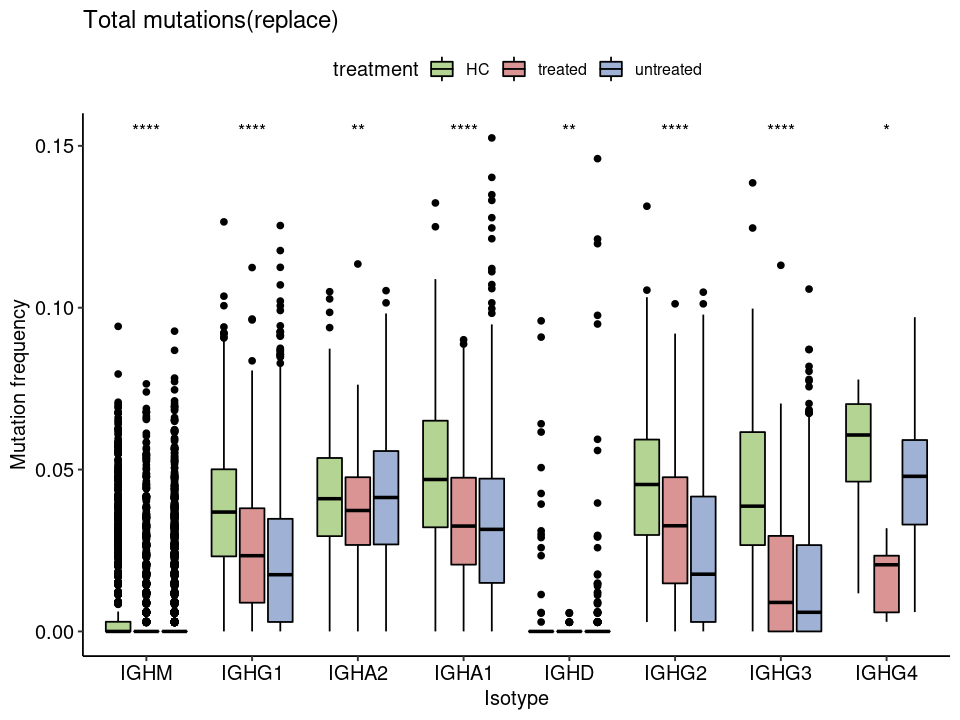

In [27]:
options(repr.plot.width=8, repr.plot.height=6)
ggboxplot(db_obs_all, "c_call", "mu_freq_seq_r", fill = "treatment",
 palette =  c("#B4D493", "#DA9494","#9FB1D4")) + ggtitle("Total mutations(replace)") +
    xlab("Isotype") + ylab("Mutation frequency")  +
    theme_pubr() + stat_compare_means(aes(group = treatment ), label = "p.signif", method = 'anova')

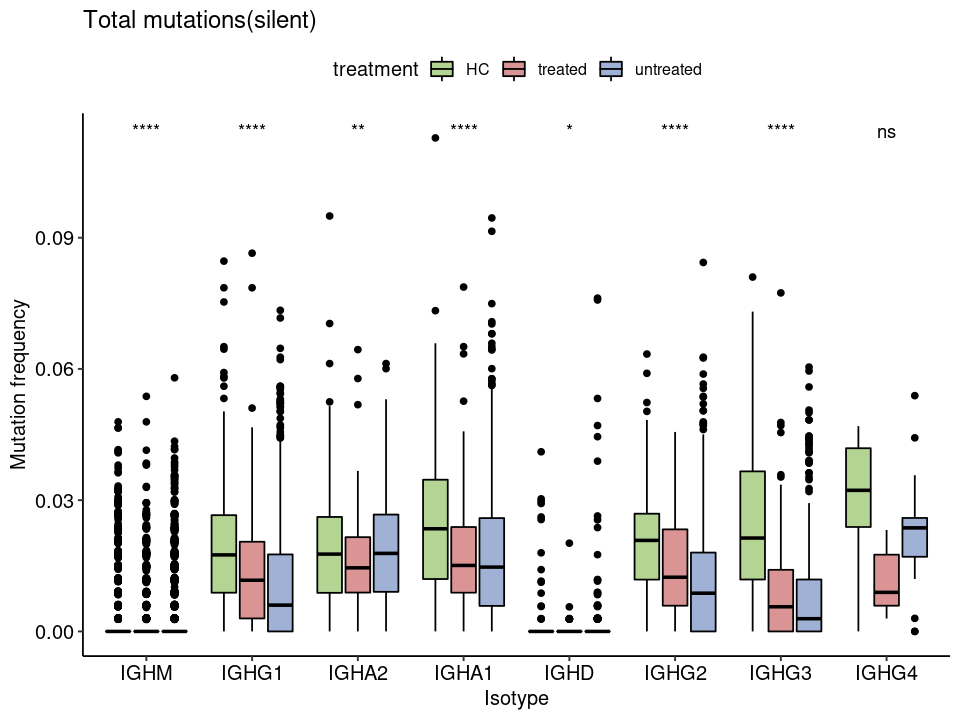

In [28]:
options(repr.plot.width=8, repr.plot.height=6)
ggboxplot(db_obs_all, "c_call", "mu_freq_seq_s", fill = "treatment",
 palette =  c("#B4D493", "#DA9494","#9FB1D4")) + ggtitle("Total mutations(silent)") +
    xlab("Isotype") + ylab("Mutation frequency")  +
    theme_pubr() + stat_compare_means(aes(group = treatment ), label = "p.signif", method = 'anova')

In [16]:
write.csv(db_obs_all,'/rd2/user/xiacr/sle/scripts/immcantaion/bcell_immacantation_SHM.csv')

# IGH gene usage

In [20]:
filter_all_df_sle <- filter_all_df[which(filter_all_df$disease == 'SLE'),]
filter_all_df_hc <- filter_all_df[which(filter_all_df$disease == 'HC'),]
dim(filter_all_df_sle)
dim(filter_all_df_hc)

[1] 20200    82

[1] 3827   82

In [22]:
pie_plot <- function(data, count, group, title, out = False){
    # Compute percentages
    data$fraction <- data[[count]] / sum(data[[count]])

    # Compute the cumulative percentages (top of each rectangle)
    data$ymax <- cumsum(data$fraction)

    # Compute the bottom of each rectangle
    data$ymin <- c(0, head(data$ymax, n=-1))

    # Compute label position
    data$labelPosition <- (data$ymax + data$ymin) / 2

    # Compute a good label
    data$label <- paste0(data[[group]], " ", data[[count]])

    # Make the plot
    ggplot(data, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=get(group))) +
    geom_rect() +
    geom_text_repel( x=2, aes(y=labelPosition, label=label, color=get(group)), size=5) + # x here controls label position (inner / outer)
    scale_fill_brewer(palette='RdBu', direction=1) +
    scale_color_brewer(palette='RdBu', direction=1) +
    # scale_fill_manual() +
    # scale_color_manual() + 
    coord_polar(theta="y") +
    xlim(c(-1, 4)) +
    theme_void() +
    theme(legend.position = "none")
}

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


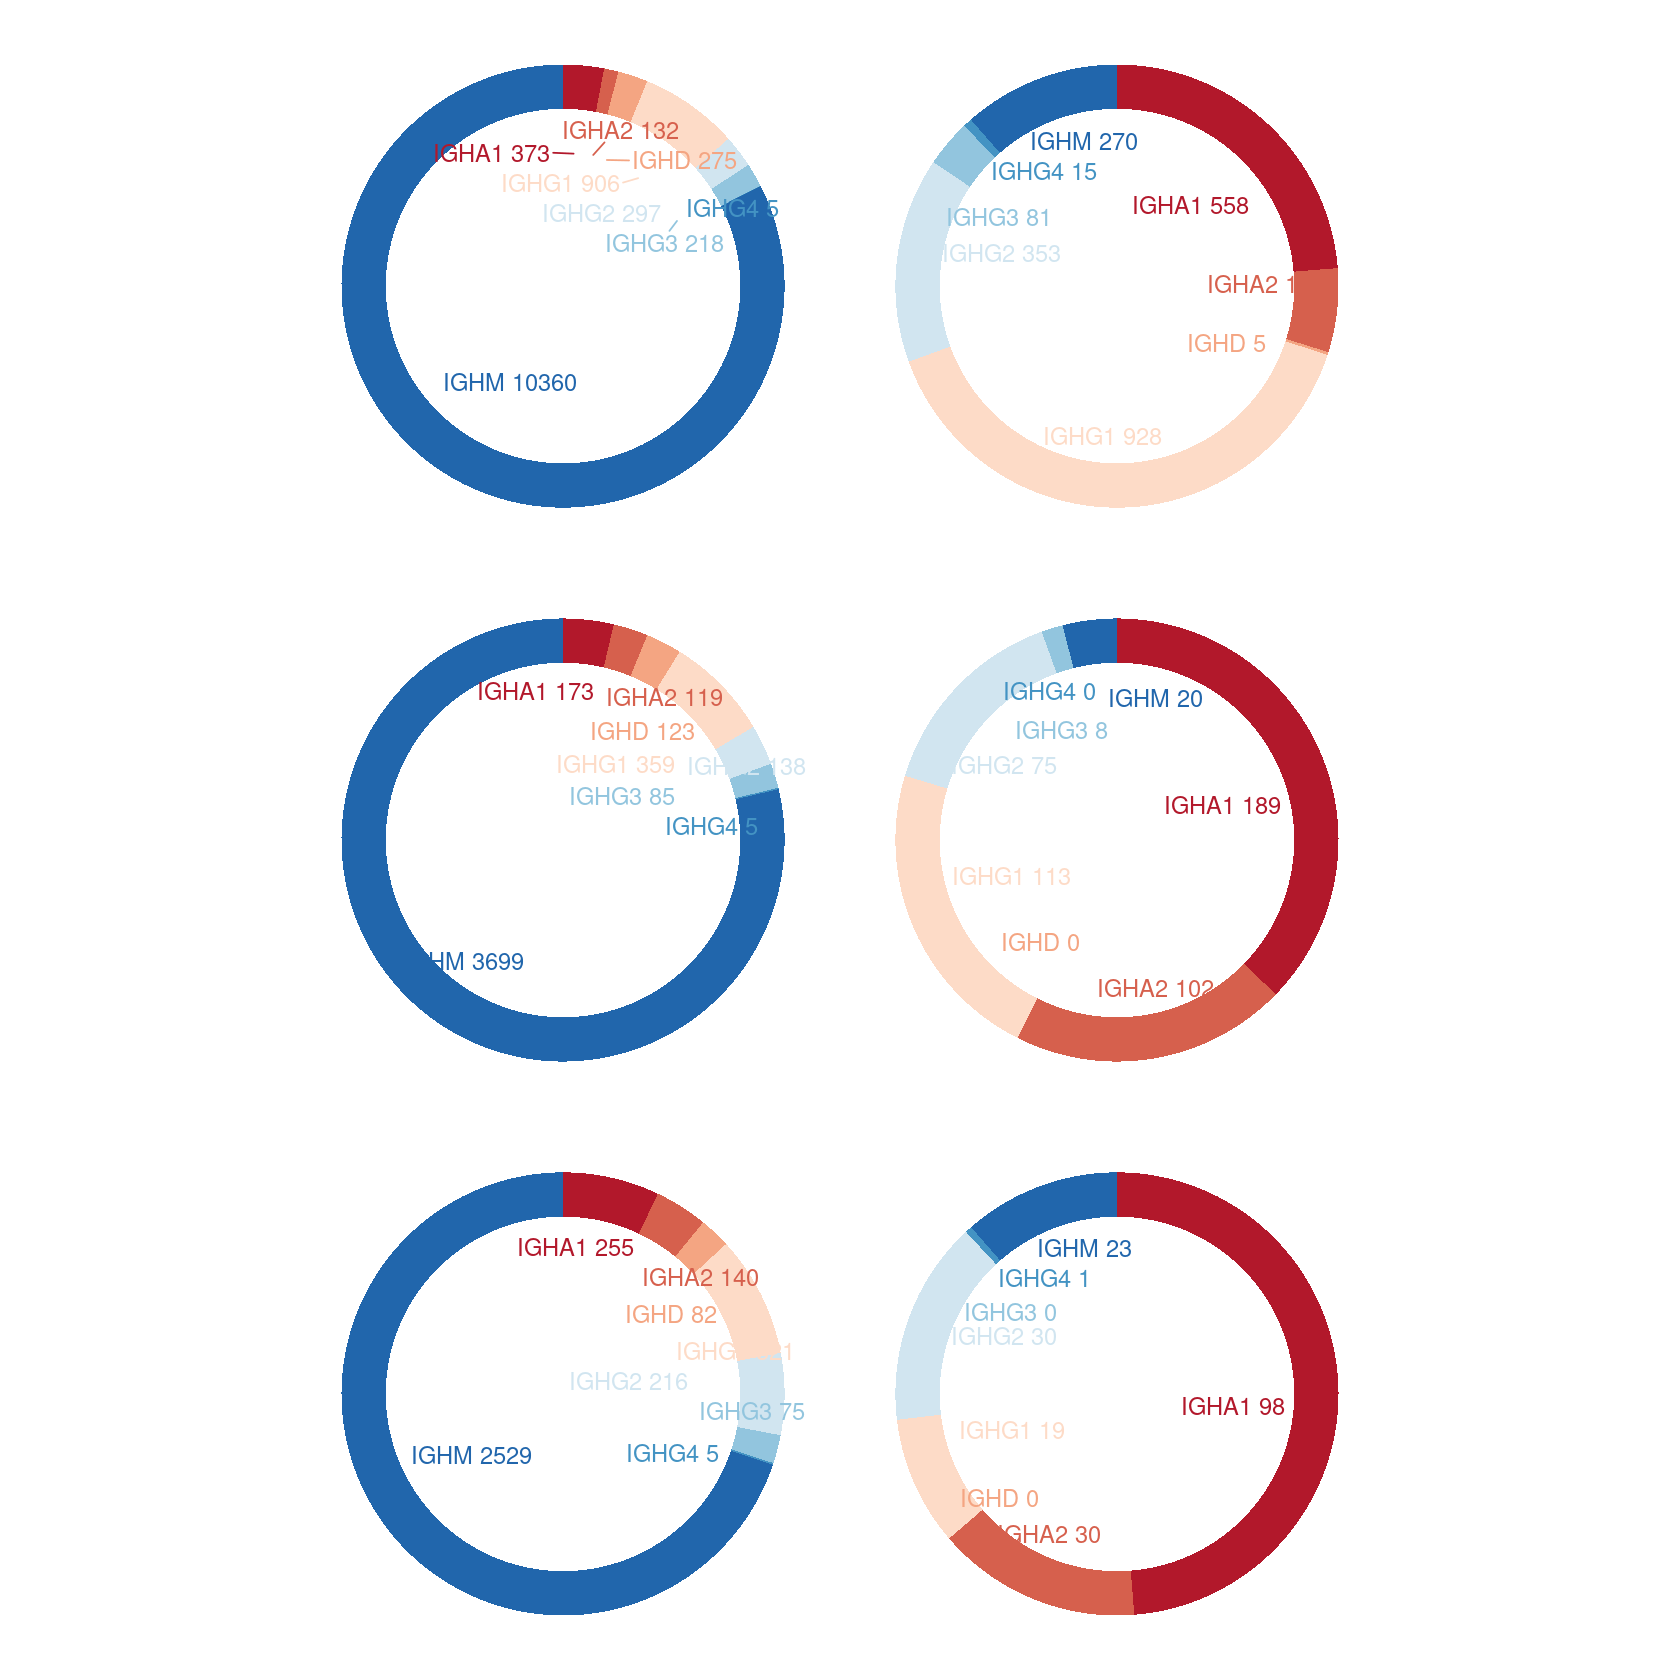

In [23]:
# sle_pre
filter_all_df_sle_before <- filter_all_df_sle %>% filter(treatment == 'untreated')
sle_c_pie <- table(filter_all_df_sle_before$c_call , filter_all_df_sle_before$main_type) %>% data.frame()
sle_c_pie_bcell <- sle_c_pie %>% filter(Var2 == 'Bcell') %>% filter(Var1 != '')
colnames(sle_c_pie_bcell) <- c('C gene','main_type','count')
a <- pie_plot(sle_c_pie_bcell,'count','C gene')

sle_c_pie_plasma <- sle_c_pie %>% filter(Var2 == 'Plasma') %>% filter(Var1 != '')
colnames(sle_c_pie_plasma) <- c('C gene','main_type','count')
b <- pie_plot(sle_c_pie_plasma,'count','C gene')

# sle_after
filter_all_df_sle_after <- filter_all_df_sle %>% filter(treatment == 'treated')
sle_c_pie <- table(filter_all_df_sle_after$c_call , filter_all_df_sle_after$main_type) %>% data.frame()
sle_c_pie_bcell <- sle_c_pie %>% filter(Var2 == 'Bcell') %>% filter(Var1 != '')
colnames(sle_c_pie_bcell) <- c('C gene','main_type','count')
c <- pie_plot(sle_c_pie_bcell,'count','C gene')

sle_c_pie_plasma <- sle_c_pie %>% filter(Var2 == 'Plasma') %>% filter(Var1 != '')
colnames(sle_c_pie_plasma) <- c('C gene','main_type','count')
d <- pie_plot(sle_c_pie_plasma,'count','C gene')


# hc
hc_c_pie <- table(filter_all_df_hc$c_call , filter_all_df_hc$main_type) %>% data.frame()
hc_c_pie_bcell <- hc_c_pie %>% filter(Var2 == 'Bcell') %>% filter(Var1 != '')
colnames(hc_c_pie_bcell) <- c('C gene','main_type','count')
e <- pie_plot(hc_c_pie_bcell,'count','C gene')

hc_c_pie_plasma <- hc_c_pie %>% filter(Var2 == 'Plasma') %>% filter(Var1 != '')
colnames(hc_c_pie_plasma) <- c('C gene','main_type','count')
f <- pie_plot(hc_c_pie_plasma,'count','C gene')

options(repr.plot.width=14, repr.plot.height=14)
library(patchwork)
(a+b)/(c+d)/(e+f)

.
B.IFN-response          B.mem    B.mem.CD27-   B.mem.CXCR3+    B.mem.IGHM+ 
          1542           2032           1415           2230           1250 
       B.naive   B.transition         plasma 
         10109           2388           3061 

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


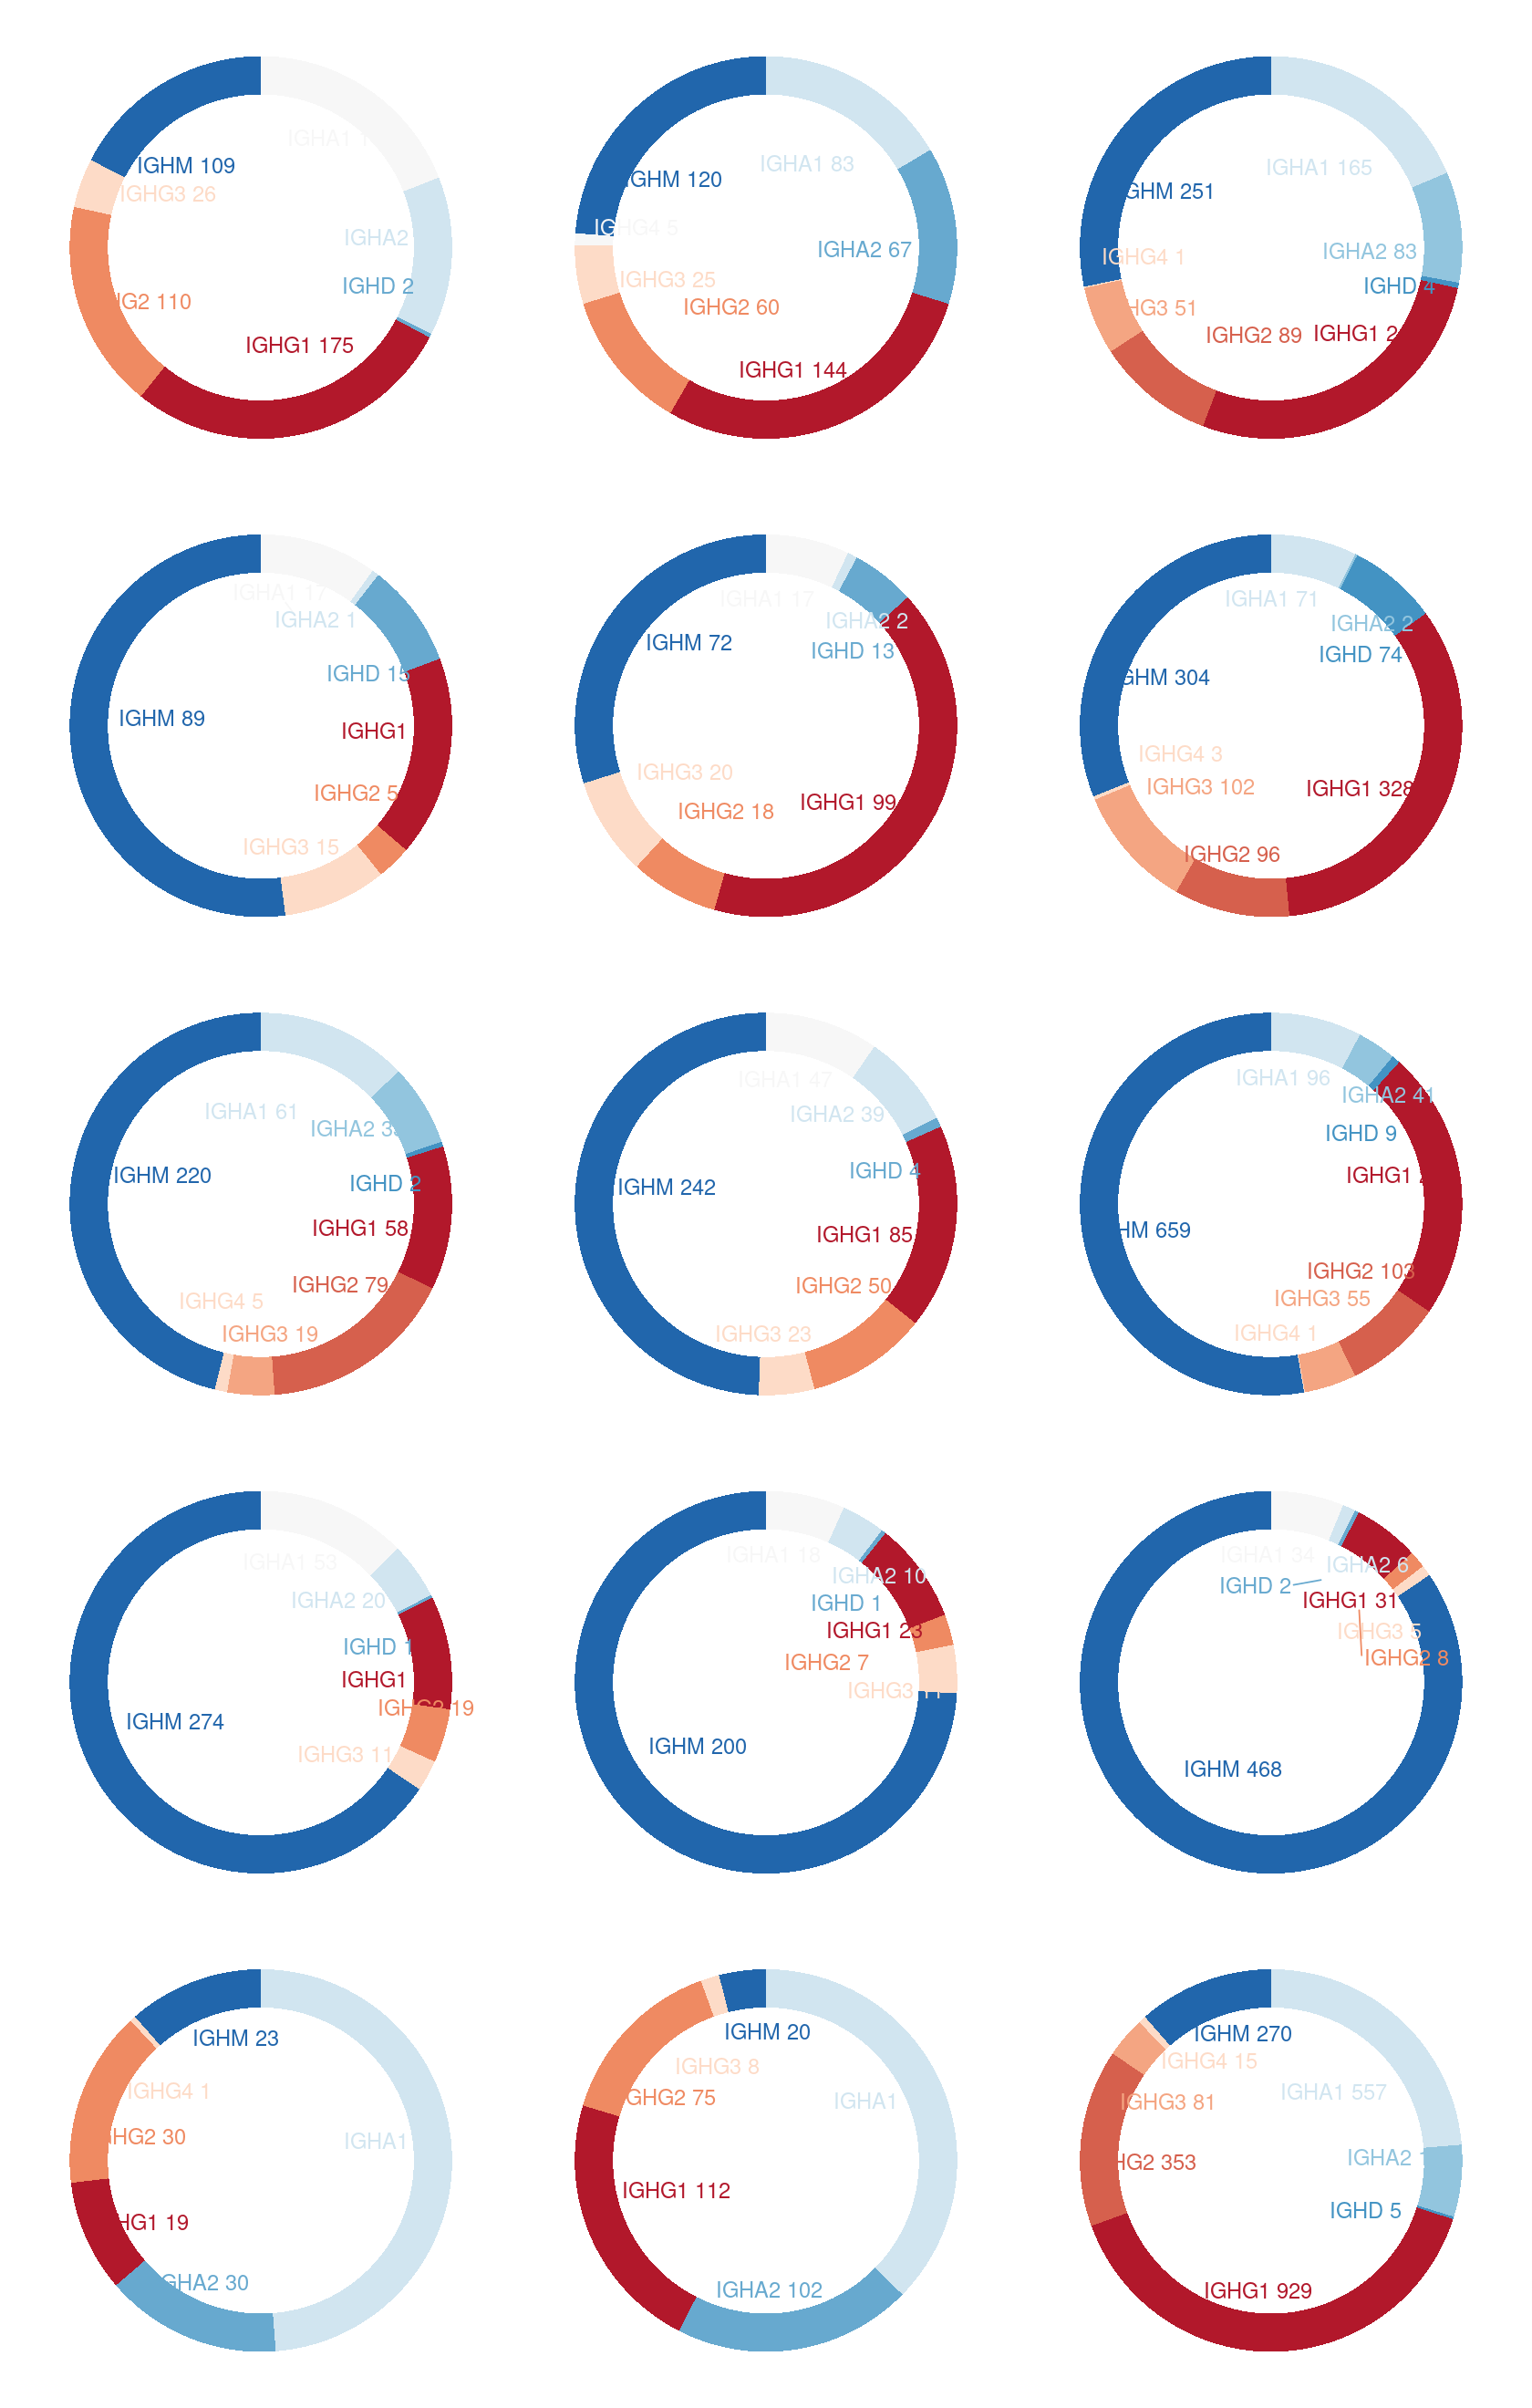

In [24]:
filter_all_df$subtype[grepl(filter_all_df$subtype,pattern = 'plasma')] <- 'plasma'
filter_all_df$subtype %>% table()
sub_filter_all_df <- filter_all_df %>% filter(!subtype %in% c('B.naive','B.IFN-response','B.transition')) 
p2_list <- list();j = 1
for (treatment in c('HC','treated','untreated')) {
    # print(treatment)
    sub <- sub_filter_all_df[which(sub_filter_all_df$treatment == treatment),]
    p_list <- list()
    i = 1
    for (celltype in c('B.mem','B.mem.CD27-','B.mem.CXCR3+','B.mem.IGHM+','plasma')){
        # print(celltype)
        sub2 <- sub[which(sub$subtype == celltype),]
        # plot
        plot_tab <- table(sub2$c_call , sub2$subtype) %>% data.frame() %>% filter(Var1 != '')
        colnames(plot_tab) <- c('C gene','subtype','count')
        # print(head(plot_tab))
        plot_tab[['C gene']] <- factor(plot_tab[['C gene']], 
                             levels = c('IGHG1','IGHG2','IGHG3','IGHG4','IGHA1','IGHA2','IGHD','IGHM'))
        # break()
        p <- pie_plot(plot_tab,'count','C gene')
        p_list[[i]] <- p
        # names(p_list[[i]]) <- paste0(treatment,celltype)
        i = i+1
    }
    p2 <- do.call(patchwork::wrap_plots,c(p_list,ncol =1)) 
    p2_list[[j]] <- p2; j = j+1
}
options(repr.plot.width=14, repr.plot.height=22)
f5e <- do.call(patchwork::wrap_plots,c(p2_list,ncol =3))
f5e

In [90]:
# ggsave('../../../Figure/f5e.svg', f5e, dpi = 600, width =14, height = 22)

# VDJ gene usage
## V gene


In [29]:
# gene_usage_hc <- countGenes(HC_df, gene="v_call", groups="sample", mode="gene")
# gene_usage_sle <- countGenes(SLE_df, gene="v_call", groups="sample", mode="gene")
 gene_usage_all <- countGenes(filter_all_df, gene="v_call", groups="sample", mode="gene")

In [31]:
unique(filter_all_df[,c('orig.ident','group')]) %>% head()

,orig.ident,group
,<chr>,<chr>
1,GW,SLE
809,GZR,SLE
1678,HXR,SLE
3223,HXR2,SLE
3787,HXX,SLE
6483,LGY,SLE


In [21]:
unique(filter_all_df[,c('orig.ident','group')]) %>% write.csv('meta.csv')

In [22]:
gene_usage_all %<>% left_join(unique(filter_all_df[,c('orig.ident','group')]), by = c('sample' = 'orig.ident'))

In [23]:
gene_usage_all %<>% arrange(gene)

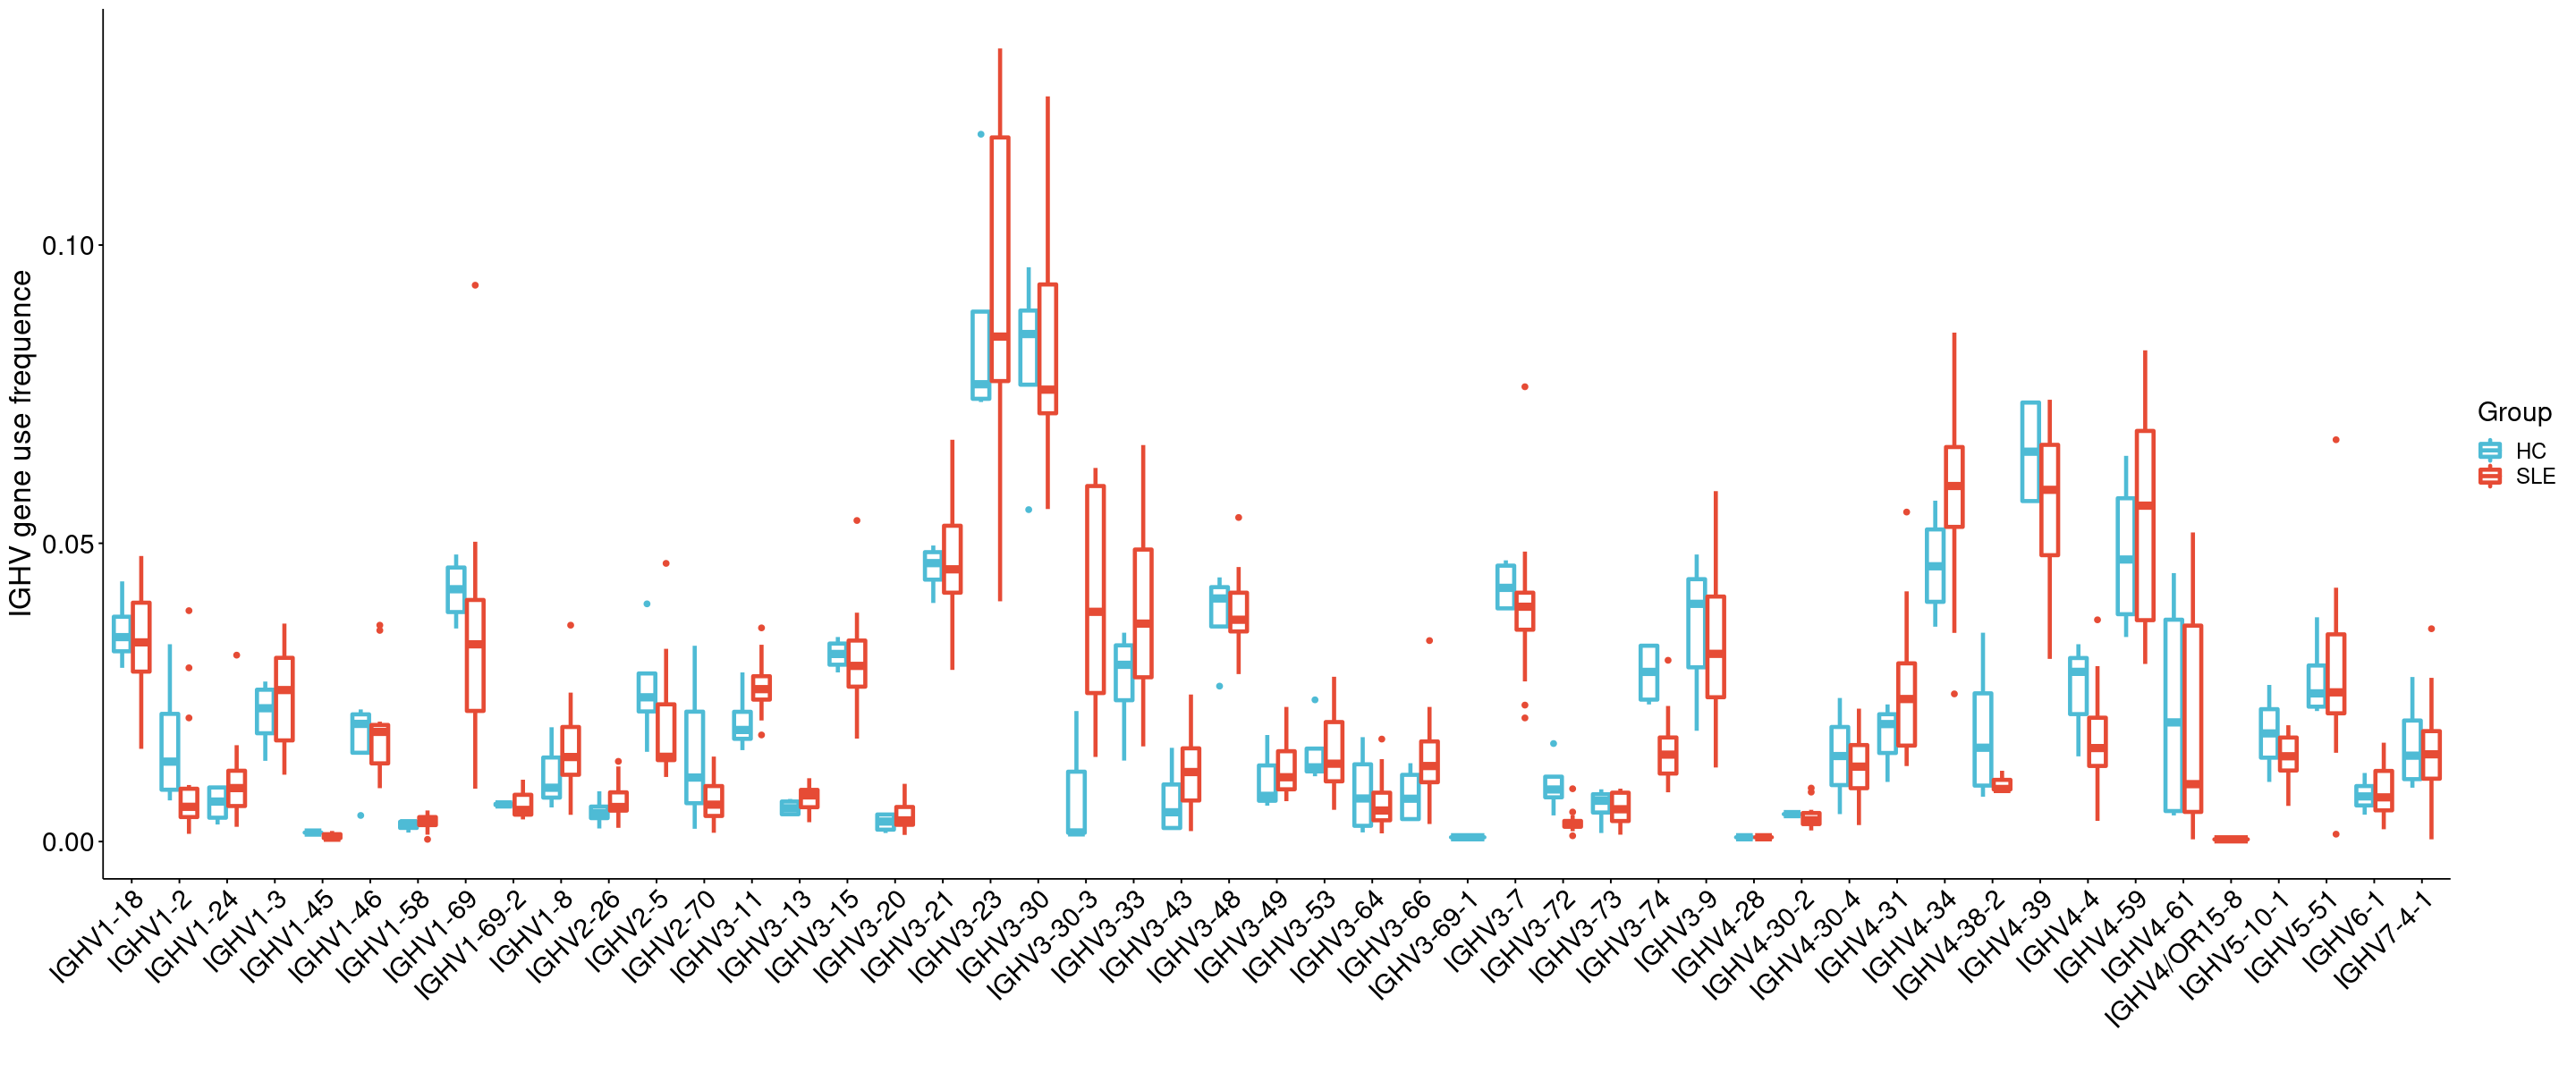

In [44]:
options(repr.plot.width=24, repr.plot.height=10)
f2a <-ggboxplot(gene_usage_all, "gene", "seq_freq", color = "group", palette = c('#4EBBD5','#E64B35'), legend = 'right', size=1.3) +
    theme(text=element_text(size=18), axis.text.x=element_text(angle=45, hjust=1), axis.title.y=element_text(size = 20)) + xlab('') + 
ylab('IGHV gene use frequence') + labs(color='Group')
ggsave('../../../Figure/f2a.svg', f2a, dpi = 600, width = 24, height = 10)
f2a

In [192]:
ighv1 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV1") %>% left_join(meta,by = c('sample'='name'))

# Plot V gene usage in the IGHV1 family by sample
g1 <- ggplot(ighv1, aes(x=gene, y=seq_freq)) +
    theme_bw() +
    ggtitle("IGHV1 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +
    xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

# IGV2
g2 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV2") %>% left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHV2 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

# IGV3
g3 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV3") %>% left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHV3 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

# IGV4
g4 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV4") %>% left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHV4 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)


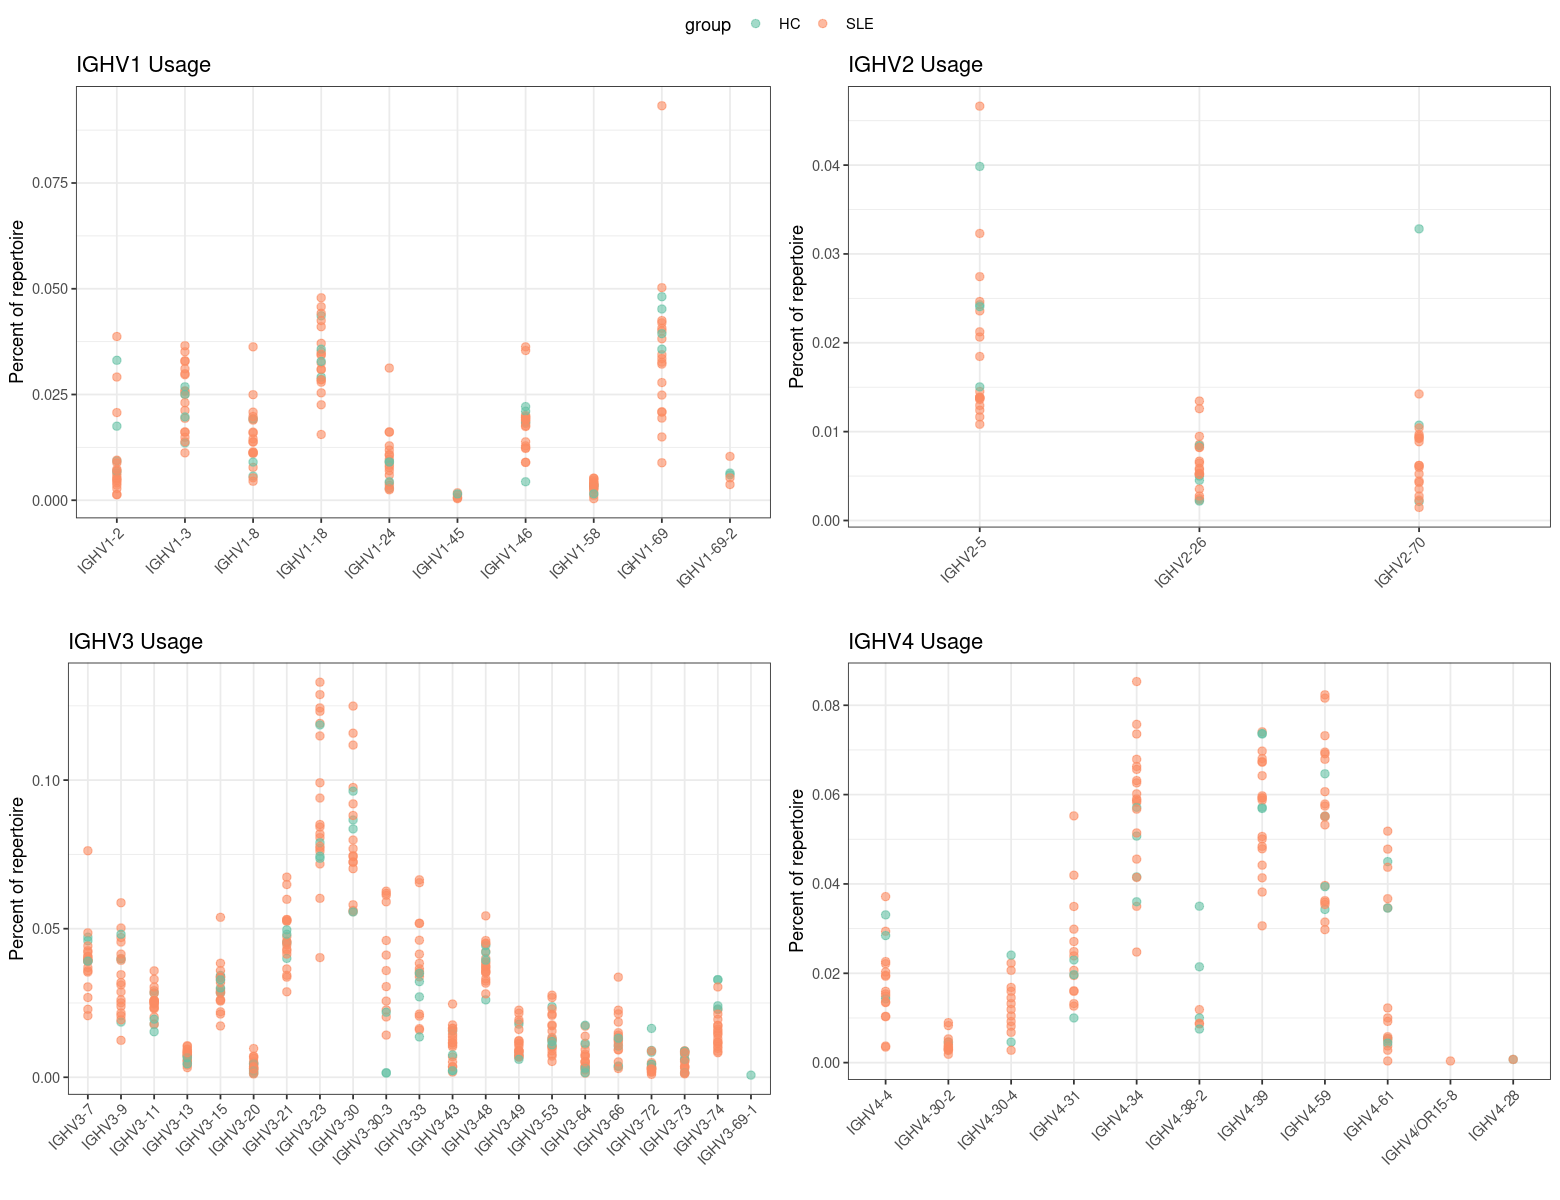

In [193]:
options(repr.plot.width=13, repr.plot.height=10)
ggarrange(g1,g2,g3,g4,common.legend = TRUE)

## Fisher test

In [109]:
# all_df$v_call_10x %>% head()
# all_df$v_call %>% head()

[1] "IGHV3-74" "IGHV3-30" "IGHV1-8"  "IGHV3-53" "IGHV3-74" "IGHV3-53"

[1] "IGHV3-74*01"                          
[2] "IGHV3-30*04,IGHV3-30*18,IGHV3-30-3*03"
[3] "IGHV1-8*01"                           
[4] "IGHV3-53*01"                          
[5] "IGHV3-74*03"                          
[6] "IGHV3-53*01"

In [103]:
fisher.result <- data.frame(matrix(NA, ncol =  3, nrow = 0))
group_counts <- gene_usage_all %>% group_by(group) %>% summarise(sum = sum(seq_count))
gene_freq_grouped <- gene_usage_all %>% group_by(group, gene) %>% summarise(sum = sum(seq_count))
all_hc <- group_counts %>% filter(group=='HC')
all_sle <- group_counts %>% filter(group=='SLE')

for (i in unique(gene_usage_all$gene)) {
    # print(i)
    gene_sle <- gene_freq_grouped %>% filter(gene==i, group=='SLE')
    gene_hc <- gene_freq_grouped %>% filter(gene==i, group=='HC')
    if (dim(gene_sle)[1] * dim(gene_hc)[1] ==0){
        fisher.result <- rbind(fisher.result, c(0, 0))
        print('error')
        next
    }

    tmp_df <- data.frame("SLE" = c(gene_sle[['sum']], all_sle[['sum']]-gene_sle[['sum']]),
                         "HC" = c(gene_hc[['sum']], all_hc[['sum']]-gene_hc[['sum']]),
                     row.names = c("This_gene", "Other"))
    tmp_fisher <- fisher.test(tmp_df)
    fisher.result <- rbind(fisher.result, c(tmp_fisher$p.value,tmp_fisher$conf.int))
    # print('------------')
}

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.



[1] "error"
[1] "error"


In [104]:
fisher.result

X0.845786634324792,X0.811550489008562,X1.19695611911042
<dbl>,<dbl>,<dbl>
8.457866e-01,0.811550489,1.1969561
1.562040e-01,0.587211675,1.1056511
6.057155e-02,0.984920488,2.4226040
6.871306e-01,0.836068794,1.3417897
1.000000e+00,0.105953264,44.8149224
4.120867e-01,0.689111884,1.1757221
1.000000e+00,0.546064364,2.3746043
2.283656e-03,0.631145694,0.9069878
2.380445e-06,0.041766225,0.3028395


In [26]:
fisher.result <- data.frame(matrix(NA, ncol =  3, nrow = 0))
for (i in unique(filter_all_df$v_call_10x)){
    this_gene_sle <- filter_all_df %>% filter(disease=='SLE',v_call_10x==i) %>% dim()
    this_gene_hc <- filter_all_df %>% filter(disease=='HC',v_call_10x==i) %>% dim()
    not_this_gene_sle <- table(filter_all_df$disease)[2] - this_gene_sle[1]
    not_this_gene_hc <- table(filter_all_df$disease)[1] - this_gene_hc[1]
    tmp_df <- data.frame("SLE" = c(this_gene_sle[1], not_this_gene_sle),"HC" = c(this_gene_hc[1], not_this_gene_hc), 
                     row.names = c("This_gene", "Other"))
    tmp_fisher <- fisher.test(tmp_df)
    fisher.result <- rbind(fisher.result, c(tmp_fisher$p.value, tmp_fisher$conf.int))
    # print('------------')
}
fisher.result %>% head()

,X2.73553792170008e.08,X0.404520134343567,X0.644751910742688
,<dbl>,<dbl>,<dbl>
1,2.735538e-08,0.4045201,0.6447519
2,8.891415e-14,1.8136889,3.0161402
3,1.431840e-01,0.9239350,1.8386736
4,2.590975e-01,0.6396253,1.1422759
5,9.224557e-01,0.8175143,1.2071930
6,2.658630e-02,0.7353809,0.9838599


In [106]:
colnames(fisher.result) <- c('p.value','down','up')
rownames(fisher.result) <- unique(gene_usage_all$gene)
fisher.result$gene <- rownames(fisher.result)
fisher.result$mean <- 0.5*(fisher.result$down + fisher.result$up)


In [107]:
fisher.result %<>% filter(mean < 10)

,p.value,down,up,gene,mean
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
IGHV1-18,8.457866e-01,0.811550489,1.1969561,IGHV1-18,1.0042533
IGHV1-2,1.562040e-01,0.587211675,1.1056511,IGHV1-2,0.8464314
IGHV1-24,6.057155e-02,0.984920488,2.4226040,IGHV1-24,1.7037622
IGHV1-3,6.871306e-01,0.836068794,1.3417897,IGHV1-3,1.0889293
IGHV1-46,4.120867e-01,0.689111884,1.1757221,IGHV1-46,0.9324170
IGHV1-58,1.000000e+00,0.546064364,2.3746043,IGHV1-58,1.4603343
IGHV1-69,2.283656e-03,0.631145694,0.9069878,IGHV1-69,0.7690667
IGHV1-69-2,2.380445e-06,0.041766225,0.3028395,IGHV1-69-2,0.1723029
IGHV1-8,7.587943e-02,0.964926770,1.9506306,IGHV1-8,1.4577787


In [127]:
options(repr.plot.width =10, repr.plot.height=9)

s2a <- ggplot(fisher.result, aes(x=gene, y=mean)) + 
  geom_point(size =5, color = ifelse(fisher.result$p.value < 0.05, "red", "gray"),)+ xlab('') + ylab('odd ratio')  +
  geom_errorbar(aes(ymin=down, ymax=up), width=0.6, size=1, color = ifelse(fisher.result$p.value < 0.05, "red", "gray"),
                position=position_dodge(0.05)) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
geom_hline(aes(yintercept=1), color="#708090", linetype="dashed") +
  geom_text(aes(x = gene, y = up, label = sprintf("%.2f", p.value)), nudge_y = 0.5)+
    coord_flip() + theme(panel.grid.major=element_line(colour=NA))  + theme_classic()
ggsave('../../../Figure/s2a.svg',  dpi = 600, width = 10, height = 9)

## J gene

In [128]:
gene_usage_all_j <- countGenes(filter_all_df, gene="j_call", groups="sample", mode="gene")
options(repr.plot.width=13, repr.plot.height=10)
gene_usage_all_j$gene %>% table()

.
IGHJ1 IGHJ2 IGHJ3 IGHJ4 IGHJ5 IGHJ6 
   22    22    22    22    22    22 

In [40]:
gene_usage_all_j %<>% left_join(unique(filter_all_df[,c('orig.ident','group')]), by = c('sample' = 'orig.ident')) %>% arrange(gene)

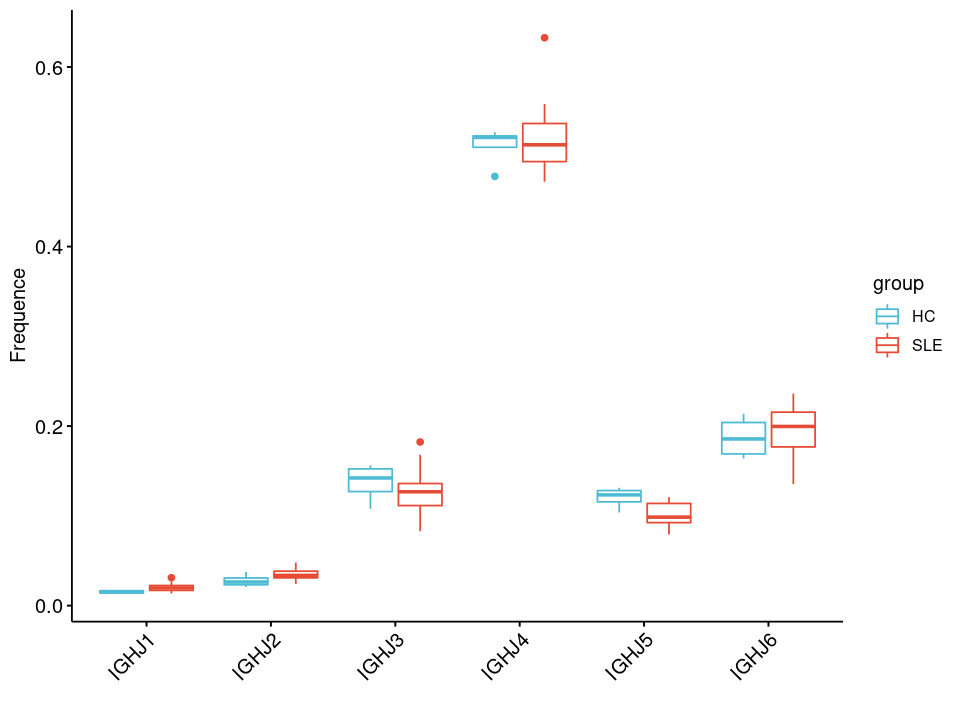

In [51]:
options(repr.plot.width=8, repr.plot.height=6)
ggboxplot(gene_usage_all_j, "gene", "seq_freq", color = "group",palette = c('#4EBBD5','#E64B35'), legend = 'right') +  theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('Frequence')

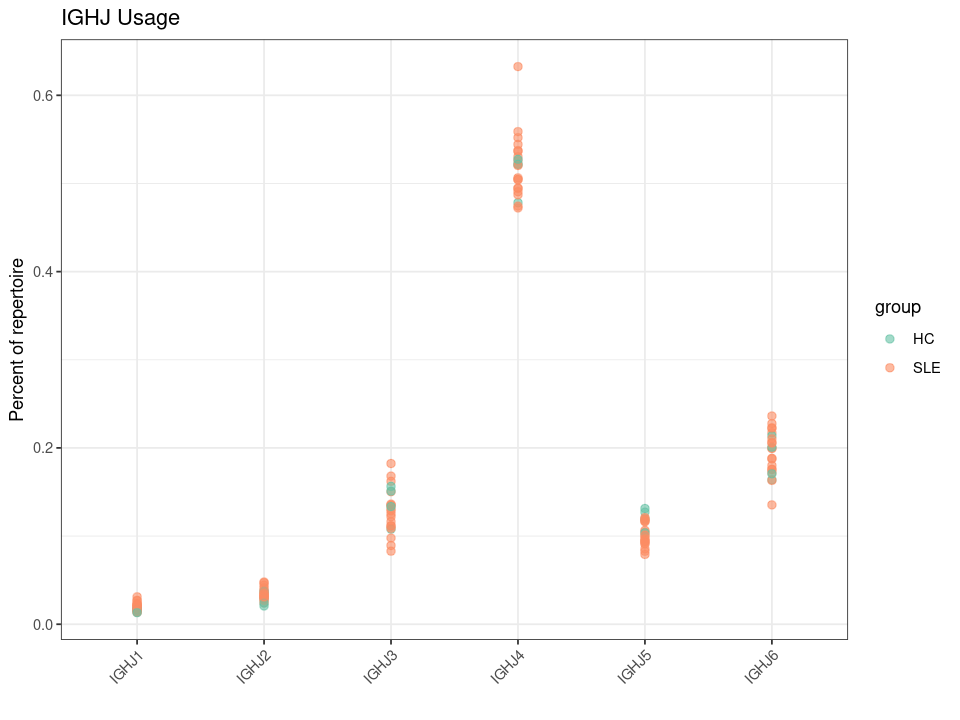

In [205]:
options(repr.plot.width =8, repr.plot.height=6)
gene_usage_all_j %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    # filter(getFamily(gene) == "IGHV1") %>% 
    left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHJ Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

In [132]:
 gene_usage_all_j %>% head()

sample,gene,seq_count,seq_freq
<chr>,<chr>,<int>,<dbl>
HXX,IGHJ4,1430,0.5304154
LGY,IGHJ4,1355,0.5042799
XYY2,IGHJ4,922,0.5372960
HXR,IGHJ4,829,0.5365696
ZH,IGHJ4,730,0.5214286
WYF,IGHJ4,713,0.4907089


In [155]:
fisher.result_j <- data.frame(matrix(NA, ncol =  3, nrow = 0))
group_counts_j <- gene_usage_all_j %>% group_by(group) %>% summarise(sum = sum(seq_count))
gene_freq_grouped_j <- gene_usage_all_j %>% group_by(group, gene) %>% summarise(sum = sum(seq_count))
all_hc_j <- group_counts_j %>% filter(group=='HC')
all_sle_j <- group_counts_j %>% filter(group=='SLE')

for (i in unique(gene_usage_all_j$gene)) {
    # print(i)
    gene_sle_j <- gene_freq_grouped_j %>% filter(gene==i, group=='SLE')
    gene_hc_j <- gene_freq_grouped_j %>% filter(gene==i, group=='HC')
    if (dim(gene_sle_j)[1] * dim(gene_hc_j)[1] ==0){
        fisher.result_j <- rbind(fisher.result_j, c(0, 0))
        print('error')
        next
    }

    tmp_df <- data.frame("SLE" = c(gene_sle_j[['sum']], all_sle_j[['sum']]-gene_sle_j[['sum']]),
                         "HC" = c(gene_hc_j[['sum']], all_hc_j[['sum']]-gene_hc_j[['sum']]),
                     row.names = c("This_gene", "Other"))
    tmp_fisher <- fisher.test(tmp_df)
    fisher.result_j <- rbind(fisher.result_j, c(tmp_fisher$p.value,tmp_fisher$conf.int))
    # print('------------')
}

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.



In [156]:
colnames(fisher.result_j) <- c('p.value','down','up')
rownames(fisher.result_j) <- unique(all_df$j_call_10x)
fisher.result_j$gene <- rownames(fisher.result_j)
fisher.result_j$mean <- 0.5*(fisher.result_j$down + fisher.result_j$up)

In [157]:
options(repr.plot.width=8, repr.plot.height=6)
s2b <- ggplot(fisher.result_j, aes(x=gene, y=mean)) + 
  geom_point(size = 4, color = ifelse(fisher.result_j$p.value < 0.05, "red", "gray"),)+ xlab('') + ylab('odd ratio')  +
  geom_errorbar(aes(ymin=down, ymax=up), width=.2, color = ifelse(fisher.result_j$p.value < 0.05, "red", "gray"),
                position=position_dodge(0.05)) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
geom_hline(aes(yintercept=1), colour="#708090", linetype="dashed") +
  geom_text(aes(x = gene, y = up, label = paste0('',sprintf("%.2f", p.value))), 
            nudge_y =0.03 )+
    coord_flip() + theme(panel.grid.major=element_line(colour=NA), text = element_text(size = 15)) + theme_classic()
ggsave('../../../Figure/s2b.svg', s2b,  dpi = 600, width = 5, height = 4)

# Physics and chemsitry  properties 

In [219]:
all_df %<>% filter(c_call != '')
db_props <- aminoAcidProperties(all_df, seq="junction", trim=TRUE, 
                                label="cdr3")

# The full set of properties are calculated by default
# dplyr::select(db_props[1:3, ], starts_with("cdr3"))

In [229]:
aa_g1 <-  ggboxplot(db_props, "c_call", "cdr3_aa_length", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")
aa_g2 <-  ggboxplot(db_props, "c_call", "cdr3_aa_gravy", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")
aa_g3 <-  ggboxplot(db_props, "c_call", "cdr3_aa_basic", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")
aa_g4 <-  ggboxplot(db_props, "c_call", "cdr3_aa_acidic", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")

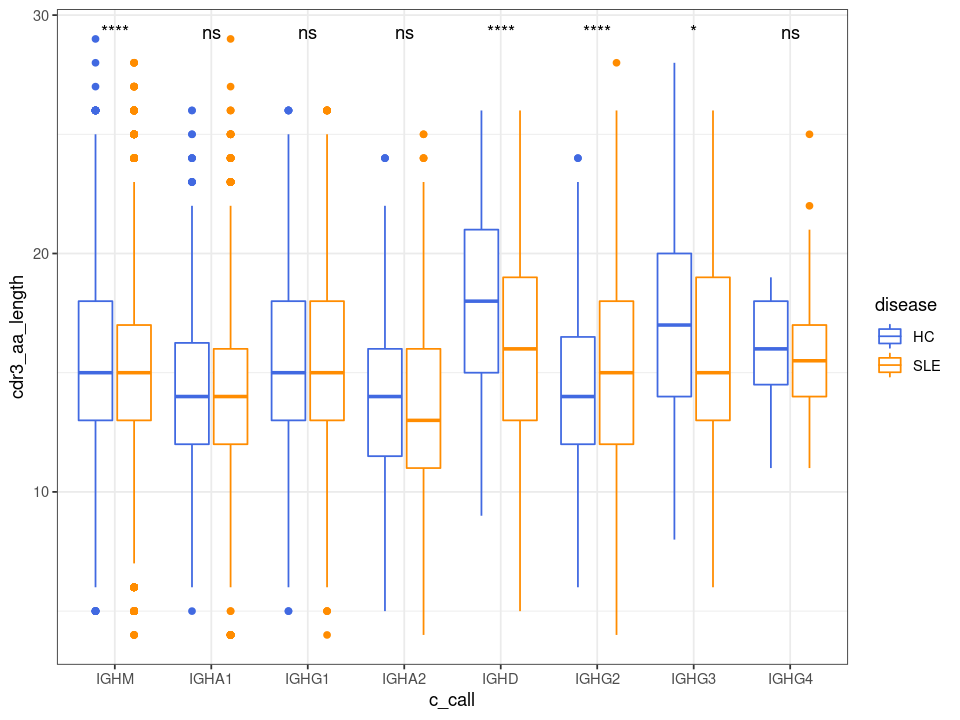

In [256]:
options(repr.plot.width =8, repr.plot.height=6)
aa_g1

$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

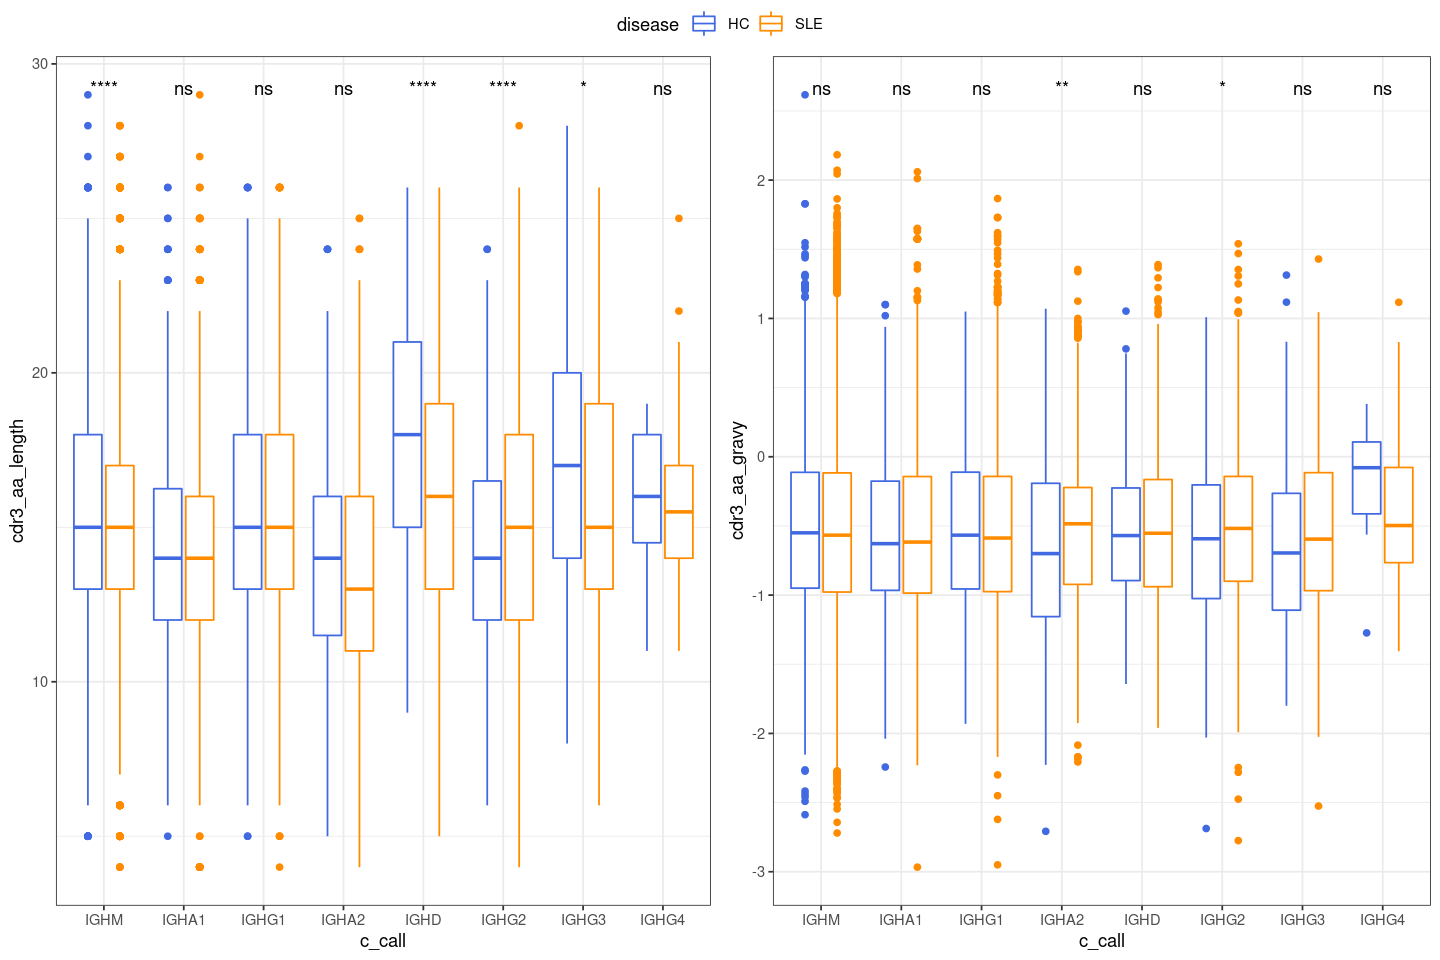

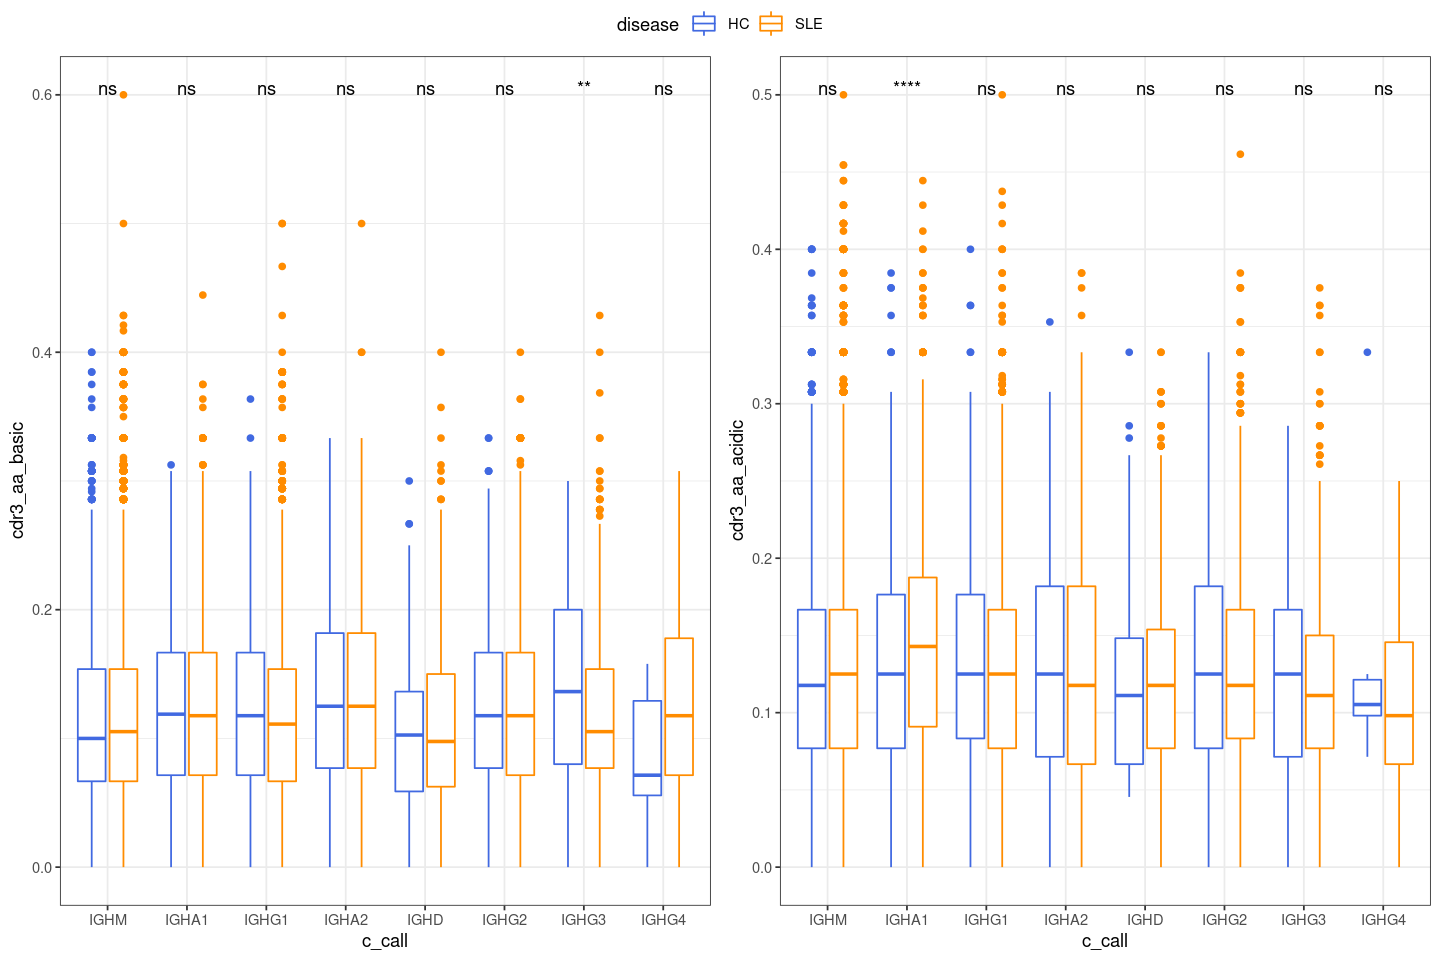

In [232]:
options(repr.plot.width =12, repr.plot.height=8)
# tmp_theme <- theme_bw() + theme(legend.position="bottom")
ggarrange(aa_g1, aa_g2, aa_g3, aa_g4, ncol=2,common.legend = TRUE)

# VH4-34 GENE


In [233]:
bcell_v4_34 <- filter_all_df %>% filter(v_call_10x == 'IGHV4-34') 
table(bcell_v4_34$disease) /table(filter_all_df$disease) 


        HC        SLE 
0.04546642 0.06004950 

In [230]:
# table(bcell_v4_34$disease,bcell_v4_34$subtype) %>% data.frame()
# table(filter_all_df$disease,filter_all_df$subtype)  %>% data.frame()
table(bcell_v4_34$disease,bcell_v4_34$subtype) 
table(filter_all_df$disease,filter_all_df$subtype)

     
      B.IFN-response B.mem B.mem.CD27- B.mem.CXCR3+ B.mem.IGHM+ B.naive
  HC               3    20          17           10          17      99
  SLE            113    43          72          117          38     542
     
      B.transition plasma plasma.IgA plasma.IgG plasmablast
  HC             6      1          0          1           0
  SLE          159     63         14         18          34

     
      B.IFN-response B.mem B.mem.CD27- B.mem.CXCR3+ B.mem.IGHM+ B.naive
  HC              60   625         172          478         419    1628
  SLE           1482  1407        1243         1752         831    8481
     
      B.transition plasma plasma.IgA plasma.IgG plasmablast
  HC           244     16        155          8          22
  SLE         2144   1104        557        441         758

In [235]:
tmp <- filter_all_df %>% filter(subtype=='B.mem.CD27-') 
dim(tmp)

[1] 1415   82

In [237]:
table(tmp$c_call)


      IGHA1 IGHA2  IGHD IGHG1 IGHG2 IGHG3 IGHG4  IGHM 
   23   105     5   102   456   119   137     3   465 